In [1]:
import os, random, torch, gym
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from networks import ActorNet, CriticNet
from custom_env import SinusoidLaneEnv
from ppo import PPOTrainer, train, evaluate

os.environ["DEVICE"]  = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
policy_lr = 3e-4
value_lr = 1e-3
gamma = 0.99
lambda_ = 0.97
epsilon = 0.2
episodes = 1_000
entropy_coef = 1e-3
n_policy_train_steps = 100
n_value_train_steps = 100
hidden_size = 128
cutoff_reward = 140

train_env = SinusoidLaneEnv()
obs_space = train_env.observation_space._shape[0]
action_space = train_env.action_space._shape[0]

obs_space, action_space

(4, 1)

In [3]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 3407
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def xavier_init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if torch.is_tensor(m.bias):
            m.bias.data.fill_(0.01)

In [4]:
policy_agent = ActorNet(obs_space, action_space, hidden_size)
value_agent = CriticNet(obs_space, hidden_size)
policy_agent.apply(xavier_init_weights)
value_agent.apply(xavier_init_weights)

policy_optimizer = torch.optim.Adam(policy_agent.parameters(), lr=policy_lr)
value_optimizer = torch.optim.Adam(value_agent.parameters(), lr=value_lr)

  0%|          | 1/1000 [00:01<28:48,  1.73s/it]

best total reward for episode 1: -51.59822420866649


  0%|          | 3/1000 [00:05<29:23,  1.77s/it]

best total reward for episode 3: 24.127420808002686


  0%|          | 4/1000 [00:06<26:47,  1.61s/it]

best total reward for episode 4: 26.800294846373433


  0%|          | 5/1000 [00:08<25:13,  1.52s/it]

best total reward for episode 5: 31.532741110877602


  1%|          | 9/1000 [00:17<43:40,  2.64s/it]

best total reward for episode 9: 37.726076365924385


  2%|▏         | 22/1000 [01:00<21:27,  1.32s/it]  

best total reward for episode 22: 39.078627631431075


  2%|▎         | 25/1000 [01:03<19:19,  1.19s/it]

best total reward for episode 25: 47.97566333697951


  5%|▍         | 49/1000 [01:34<23:22,  1.47s/it]

best total reward for episode 49: 53.79074786359388


  8%|▊         | 77/1000 [02:11<21:51,  1.42s/it]

best total reward for episode 77: 82.06230175766709


  8%|▊         | 78/1000 [02:13<22:56,  1.49s/it]

best total reward for episode 78: 101.95529834375843


 59%|█████▉    | 590/1000 [14:09<08:45,  1.28s/it]

best total reward for episode 590: 102.8509892219313


 59%|█████▉    | 591/1000 [14:10<08:47,  1.29s/it]

best total reward for episode 591: 107.415964693312


 61%|██████    | 606/1000 [14:29<08:11,  1.25s/it]

best total reward for episode 606: 110.17094267313009


 61%|██████    | 608/1000 [14:32<08:32,  1.31s/it]

best total reward for episode 608: 121.10468369666133


100%|██████████| 1000/1000 [21:50<00:00,  1.31s/it]


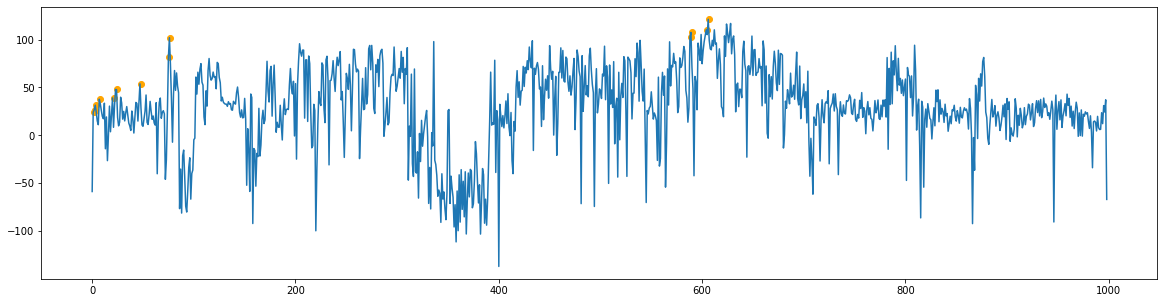

In [5]:
ppo = PPOTrainer(
        policy_agent,
        value_agent, 
        policy_optimizer, 
        value_optimizer, 
        epsilon=epsilon, 
        entropy_coef=entropy_coef, 
        n_policy_train_steps=n_policy_train_steps, 
        n_value_train_steps=n_value_train_steps, 
        clip_policy_grads=True,
        clip_value_grads=True,
        maximize_entropy=True,
    )

train_performance, best_rewards = train(
    train_env, 
    ppo, 
    n_episodes=episodes, 
    gamma=gamma, 
    lambda_=lambda_, 
    max_episode_reward=cutoff_reward,
    continue_after_max_reward=False,
    policy_weights_filename="policy.pth.tar",
    save_best_weights=True,
    verbose=True,
    close_env=True,
)

plt.figure(figsize=(20, 5))
plt.plot(train_performance["rewards"][1:])
plt.scatter(best_rewards["episodes"][1:], best_rewards["rewards"][1:], c="orange")

In [8]:
policy_agent.load_state_dict(torch.load(os.path.join(f"params/policy.pth.tar"), map_location="cpu"))
policy_agent.eval()

test_env = SinusoidLaneEnv()
evaluate(test_env, policy_agent, render_env=True, close_env=True)

(121.19168768178076, 0.20394735950231552)